In [6]:
# Cell 1: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# update this path if different
dataset_path = "/content/drive/MyDrive/Plant_Disease_Dataset (1)"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Cell 2: imports
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)


TF version: 2.19.0


In [5]:
# Cell 3: unzip (only if you uploaded a zip)
zip_path = "/content/drive/MyDrive/dataset.zip"  # change if needed
target_dir = "/content/drive/MyDrive/Plant_Disease_Dataset (1)"

if os.path.exists(zip_path):
    !unzip -qq "{zip_path}" -d "{target_dir}"
    print("unzipped to", target_dir)
else:
    print("zip not found; skipping.")


zip not found; skipping.


In [7]:
# Cell 4: inspect
data_dir = pathlib.Path(dataset_path)
def count_images(exts=('*.jpg','*.jpeg','*.png')):
    counts = {}
    for sub in [p for p in data_dir.iterdir() if p.is_dir()]:
        c = 0
        for e in exts:
            c += len(list(sub.glob(e)))
        counts[sub.name] = c
    return counts

print("Dataset folder exists:", data_dir.exists())
print("Classes and counts:", count_images())

Dataset folder exists: True
Classes and counts: {'test': 0, 'valid': 0, 'train': 0}


In [8]:
# Cell 5: create datasets
IMAGE_SIZE = (224, 224)       # change to 240/260 for EfficientNet variants
BATCH_SIZE = 32
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',    # use 'int' for sparse
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 30 files belonging to 3 classes.
Using 24 files for training.
Found 30 files belonging to 3 classes.
Using 6 files for validation.
Classes: ['test', 'train', 'valid']


In [9]:
# Cell 6: optimise pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation (in-model)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
])


In [10]:
# Cell 7: mixed precision (optional)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Compute dtype:", policy.compute_dtype, "Variable dtype:", policy.variable_dtype)


Compute dtype: float16 Variable dtype: float32


In [11]:
# Cell 8: model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
base_model.trainable = False  # freeze for initial training

inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# if mixed precision is on, set dtype float32 on final layer to avoid numeric issues
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = keras.Model(inputs, outputs)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Cell 9: compile & callbacks
model_dir = "/content/drive/MyDrive/plant_disease_models"
os.makedirs(model_dir, exist_ok=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(model_dir, "best.h5"), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]


In [13]:
# Cell 10: initial training
initial_epochs = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks
)


Epoch 1/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.3750 - loss: 1.0988

1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.3750 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.3692 - learning_rate: 0.0010
Epoch 2/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3333 - loss: 1.1655

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.3333 - loss: 1.1655 - val_accuracy: 0.3333 - val_loss: 1.3054 - learning_rate: 0.0010
Epoch 3/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5000 - loss: 1.0084

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5000 - loss: 1.0084 - val_accuracy: 0.3333 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 4/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3750 - loss: 1.0452

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.3750 - loss: 1.0452 - val_accuracy: 0.3333 - val_loss: 1.2249 - learning_rate: 0.0010
Epoch 5/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2083 - loss: 1.2235

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.2083 - loss: 1.2235 - val_accuracy: 0.3333 - val_loss: 1.2050 - learning_rate: 0.0010
Epoch 6/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4583 - loss: 0.9656

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.4583 - loss: 0.9656 - val_accuracy: 0.3333 - val_loss: 1.1924 - learning_rate: 0.0010
Epoch 7/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5000 - loss: 0.9127

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5000 - loss: 0.9127 - val_accuracy: 0.1667 - val_loss: 1.1831 - learning_rate: 0.0010
Epoch 8/8
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.6667 - loss: 0.8911 - val_accuracy: 0.1667 - val_loss: 1.1832 - learning_rate: 0.0010


In [14]:
# Cell 11: fine tuning
base_model.trainable = True

# Option: unfreeze only last N layers for stability
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_epochs = 10
total_epochs = initial_epochs + fine_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1 if hasattr(history,'epoch') else initial_epochs,
    callbacks=callbacks
)


Epoch 9/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.5833 - loss: 0.8756

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - accuracy: 0.5833 - loss: 0.8756 - val_accuracy: 0.1667 - val_loss: 1.1806 - learning_rate: 1.0000e-05
Epoch 10/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.5417 - loss: 0.9849

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.5417 - loss: 0.9849 - val_accuracy: 0.1667 - val_loss: 1.1768 - learning_rate: 1.0000e-05
Epoch 11/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5000 - loss: 0.9562

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.5000 - loss: 0.9562 - val_accuracy: 0.1667 - val_loss: 1.1727 - learning_rate: 1.0000e-05
Epoch 12/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.6250 - loss: 0.8873

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.6250 - loss: 0.8873 - val_accuracy: 0.1667 - val_loss: 1.1694 - learning_rate: 1.0000e-05
Epoch 13/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.6250 - loss: 0.9403

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.6250 - loss: 0.9403 - val_accuracy: 0.1667 - val_loss: 1.1650 - learning_rate: 1.0000e-05
Epoch 14/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.5417 - loss: 0.9620

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.5417 - loss: 0.9620 - val_accuracy: 0.1667 - val_loss: 1.1601 - learning_rate: 1.0000e-05
Epoch 15/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.4583 - loss: 0.9705

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.4583 - loss: 0.9705 - val_accuracy: 0.1667 - val_loss: 1.1568 - learning_rate: 1.0000e-05
Epoch 16/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.6250 - loss: 0.9060

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.6250 - loss: 0.9060 - val_accuracy: 0.1667 - val_loss: 1.1527 - learning_rate: 1.0000e-05
Epoch 17/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.5833 - loss: 1.0100

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.5833 - loss: 1.0100 - val_accuracy: 0.1667 - val_loss: 1.1493 - learning_rate: 1.0000e-05
Epoch 18/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.4583 - loss: 0.9575

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.4583 - loss: 0.9575 - val_accuracy: 0.1667 - val_loss: 1.1462 - learning_rate: 1.0000e-05


In [15]:
# Cell 12: evaluate & reports
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Gather truths and preds from validation set
y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
y_true_idx = np.argmax(y_true, axis=1)
y_pred_probs = model.predict(val_ds)
y_pred_idx = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true_idx, y_pred_idx, target_names=class_names))
cm = confusion_matrix(y_true_idx, y_pred_idx)
print("Confusion matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
              precision    recall  f1-score   support

        test       0.33      0.50      0.40         2
       train       0.00      0.00      0.00         3
       valid       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.11      0.17      0.13         6
weighted avg       0.11      0.17      0.13         6

Confusion matrix:
 [[1 1 0]
 [1 0 2]
 [1 0 0]]


In [17]:
# Cell 13: save
model_dir = "/content/drive/MyDrive/plant_disease_models"
os.makedirs(model_dir, exist_ok=True)

model.export(os.path.join(model_dir, "plant_classifier_saved_model"))  # SavedModel
model.save(os.path.join(model_dir, "plant_classifier.h5"))            # HDF5
print("Saved to", model_dir)

Saved artifact at '/content/drive/MyDrive/plant_disease_models/plant_classifier_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_239')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138296855408912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296855409296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296855408528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296852886928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  138296852888656: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  138296855411792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296855411984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296855412176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296855412368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138296

Saved to /content/drive/MyDrive/plant_disease_models


In [19]:
# Cell 14: inference example
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, image_size=IMAGE_SIZE):
    img = image.load_img(img_path, target_size=image_size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    preds = model.predict(arr)
    idx = np.argmax(preds[0])
    return class_names[idx], float(np.max(preds[0]))

img_path = "/content/drive/MyDrive/Plant_Disease_Dataset (1)/test/AppleCedarRust1.JPG"  # change
print(predict_image(img_path, model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
('valid', 0.5509119033813477)


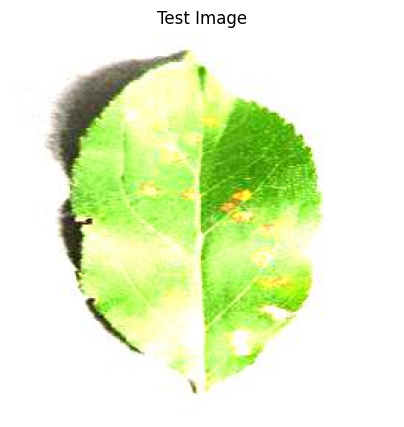

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Predicted: valid   Confidence: 0.5509


In [28]:
# Cell 5: Predict & visualize single image (change image_rel_path as required)
image_rel_path = os.path.join('test','AppleCedarRust1.JPG')  # relative to dataset_path
image_path = os.path.join(dataset_path, image_rel_path)

# 1) Display
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img_rgb)
plt.title("Test Image")
plt.axis('off')
plt.show()

# 2) Preprocess & predict
img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
arr = tf.keras.preprocessing.image.img_to_array(img)
arr = np.expand_dims(arr, axis=0)  # shape (1, H, W, 3)
# Use the same preprocessing as the training model
arr = tf.keras.applications.efficientnet.preprocess_input(arr)


preds = model.predict(arr) # Use 'model' defined in cell 'hG5u4gwNMK3F'
pred_idx = int(np.argmax(preds, axis=1)[0])
pred_conf = float(np.max(preds))
pred_label = class_names[pred_idx] if class_names else str(pred_idx)

print(f"Predicted: {pred_label}   Confidence: {pred_conf:.4f}")

In [30]:
# Cell 6: Batch predict a folder
test_folder = os.path.join(dataset_path, 'test')  # change to your test folder with images
out_csv = os.path.join(dataset_path, 'predictions.csv') # Changed filename for clarity

# get image file list by walking through subdirectories
exts = ('.jpg', '.jpeg', '.png', '.bmp')
img_files = []
for root, _, files in os.walk(test_folder):
    for f in files:
        if f.lower().endswith(exts):
            img_files.append(os.path.join(root, f))

img_files = sorted(img_files)
print("Found", len(img_files), "images in", test_folder)

results = []
batch_images = []
batch_files = []

# Import tqdm if not already imported
from tqdm import tqdm

for i, fpath in enumerate(tqdm(img_files, desc="Predicting")):
    img = tf.keras.preprocessing.image.load_img(fpath, target_size=IMAGE_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img)
    batch_images.append(arr)
    batch_files.append(fpath)
    # predict in batches
    if len(batch_images) == BATCH_SIZE or i == len(img_files)-1:
        batch_np = np.stack(batch_images, axis=0) # Removed astype(np.float32) as preprocess_input handles dtype
        # Use the same preprocessing as the training model
        batch_np = tf.keras.applications.efficientnet.preprocess_input(batch_np)
        preds = model.predict(batch_np) # Use 'model' defined in cell 'hG5u4gwNMK3F'
        pred_idxs = np.argmax(preds, axis=1)
        pred_confs = np.max(preds, axis=1)
        for fname, pidx, pconf in zip(batch_files, pred_idxs, pred_confs):
            # Ensure class_names is available from the dataset creation step
            pred_label = class_names[int(pidx)] if 'class_names' in locals() and class_names else str(int(pidx))
            results.append({
                'filename': os.path.relpath(fname, dataset_path),
                'pred_index': int(pidx),
                'pred_label': pred_label,
                'confidence': float(pconf)
            })
        batch_images = []
        batch_files = []

# Save to CSV
import pandas as pd # Import pandas if not already imported
df = pd.DataFrame(results)
df.to_csv(out_csv, index=False)
print("Saved predictions to:", out_csv)
display(df.head(10))

Found 10 images in /content/drive/MyDrive/Plant_Disease_Dataset (1)/test


Predicting:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Predicting: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

Saved predictions to: /content/drive/MyDrive/Plant_Disease_Dataset (1)/predictions.csv


,filename,pred_index,pred_label,confidence
0,test/AppleCedarRust1.JPG,2,valid,0.550920
1,test/AppleCedarRust2.JPG,0,test,0.589386
2,test/AppleCedarRust3.JPG,1,train,0.448543
3,test/AppleCedarRust4.JPG,2,valid,0.445838
4,test/AppleScab1.JPG,2,valid,0.386222
5,test/AppleScab2.JPG,0,test,0.390983
6,test/AppleScab3.JPG,0,test,0.478314
7,test/CornCommonRust1.JPG,0,test,0.624799
8,test/CornCommonRust2.JPG,0,test,0.727999
9,test/CornCommonRust3.JPG,0,test,0.579220


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pred_index'].plot(kind='hist', bins=20, title='pred_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('pred_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='pred_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='pred_index', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['pred_index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pred_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='pred_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('pred_index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['confidence']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pred_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='pred_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('confidence')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pred_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='pred_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['pred_index'].plot(kind='line', figsize=(8, 4), title='pred_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['confidence'].plot(kind='line', figsize=(8, 4), title='confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['pred_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='pred_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['pred_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='pred_index', y='pred_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['pred_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='confidence', y='pred_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)